# INM701 Coursework
### Aaron Mir (Student Number: 160001207)

In this coursework, you are expected to demonstrate what you have learned in the module by applying artificial intelligence techniques as covered in the module to a dataset and domain of your choice. This will include some or all of:

    • Define the domain and dataset(s) (you are free to choose the domain and the dataset that you want to investigate).

    • Define  questions and analysis tasks (a brief overview  of  the  domain, analytical questions that are being asked, a list of your objectives and the 
    expected output(s)of your analysis)
    
    • Perform an initial investigation of the dataset and the characteristics of the data. Develop a viable plan: which data processing steps you will need to
    perform, how you will transform the data to make it useable, which artificial intelligence techniques you can potentially use and what sorts of potential
    observations these can lead to.

    • Perform the analysis.  Get the data ready for analysis, carry out your analysis/modelling as needed, validate your results and communicate observations, 
    iterating through this process. Analytical operations can include data processing to an extent that is needed (not all datasets are messy) to prepare a useful and
    robust dataset to work within, and data derivation (such as feature engineering).

    • Split your dataset (train/validate/test, somedatasets come pre-split). If you have a holdout test set then you most likely don’t want to use this until the near 
    the end of your work.

    • You might establish a baseline result first, computing metrics on training and validation sets,  analyse  errors, work  on  succeeding iterations, and 
    alternative models. (If initial metrics are amazing and there are no errors is the problem too easy?)

    • Be  close to your data  (visualise  the  dataset,  collect  summary  statistics,  look  at  errors, analyse how different parameters affect performance, try 
    out different model variants).


## Classification of Atrial Fibrillation using a 1D Convolutional Neural Network and Random Forest
Goal: Use the Paroxysmal Atrial Fibrillation Prediction Challenge Database to build a model that can predict onset of Atrial Fibrillation (AF) from an Electrocardiogram (ECG) signal. This database contains a training set (with 50 30-minute two-lead ECGs of patients with Normal Sinus Rhythm (NSR/no signs of AF) and 50 30-minute two-lead ECGs of patients with Paroxysmal AF) and a testing set. The labels of the testing set are not known so in order to test the model, the training set will be split into training and testing sets. 

Extra goal: Use model on other databases


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.signal import filtfilt
from scipy import stats
import itertools
import sklearn
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import keras
import tensorflow.keras.utils
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, MaxPool1D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib
from keras_sequential_ascii import keras2ascii

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"Tesorflow Version: {tensorflow.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
Tesorflow Version: 2.3.0
Keras Version: 2.4.0
Sklearn Version: 0.23.1


In [3]:
''' DEFINING CONFUSION MATRIX PLOT FUNCTION TAKEN FROM SKLEARN WEBSITE'''
def plot_confusion_matrix(cm, classes, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data Preprocessing and Segmentation

In [4]:
classification = ['NSR', 'AF']
train_folder =  'data/Train'          # data in csv format
numpy_data = 'data/Numpy_Data'        # will contain X_train and y_train data after conversion to np file 

In [5]:
def bandpass_filter(X): # Function to filter the signal between 0.5Hz and 40Hz to remove baseline wander, motion artifacts, line frequency, respiratory artifacts etc.
    fs = 128.0
    highpass_cutoff = 1.0
    lowpass_cutoff = 40.0

    nyq = 0.5 *fs
    low = highpass_cutoff / nyq
    high = lowpass_cutoff / nyq
    order = 1

    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    x_bp = scipy.signal.filtfilt(b, a, X, axis=0)
    return x_bp

In [6]:
# Each ECG file has 230400 data points and two-leads so two columns per lead and 100 ECG files in total but we want to segment these in order to feed more easily into the model
def load_label_segment(location, length, filtered): 
    X = []
    y = []
    if length == '1 min':
        splitter = 30
    else: splitter = 6
    for i in classification:                                                            # iterate through each type of classification
        for data in os.listdir(location + i):
            df = pd.read_csv(location + i + '\\' + data, names=["ECG1", "ECG2"])        # load the CSV for each file per each classification
            split = np.array_split(df, splitter)                                        # splitting the data into 5 minute lengths to decrease number of convolutions and increase speed 
            for array in split:
                if filtered == True:
                    X.append(np.array(bandpass_filter(array)))
                else: X.append(np.array(array))                              # apply the filter to the ECGs
                if i == 'NSR':                                                          # label data accordingly
                    y.append(0)
                if i == 'AF':
                    y.append(1)    
    return np.array(X), np.expand_dims(np.array(y), axis=1)    

In [80]:
# Load raw ECG training data - for visual comparison below
X_train_raw, y_train_raw = load_label_segment(train_folder, '5 min', False) # '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train_raw.shape, y_train_raw.shape)

(600, 38400, 2) (600, 1)


In [7]:
# Load normalised/filtered ECG training data - Use 5 min segments for first CNN model, 1 min for second CNN
X_train, y_train = load_label_segment(train_folder, '5 min', True) # '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train.shape, y_train.shape)

(600, 38400, 2) (600, 1)


In [8]:
np.save('data/Numpy_Data/X_train.npy', X_train) # saving the training data as np files for easy access
np.save('data/Numpy_Data/y_train.npy', y_train)

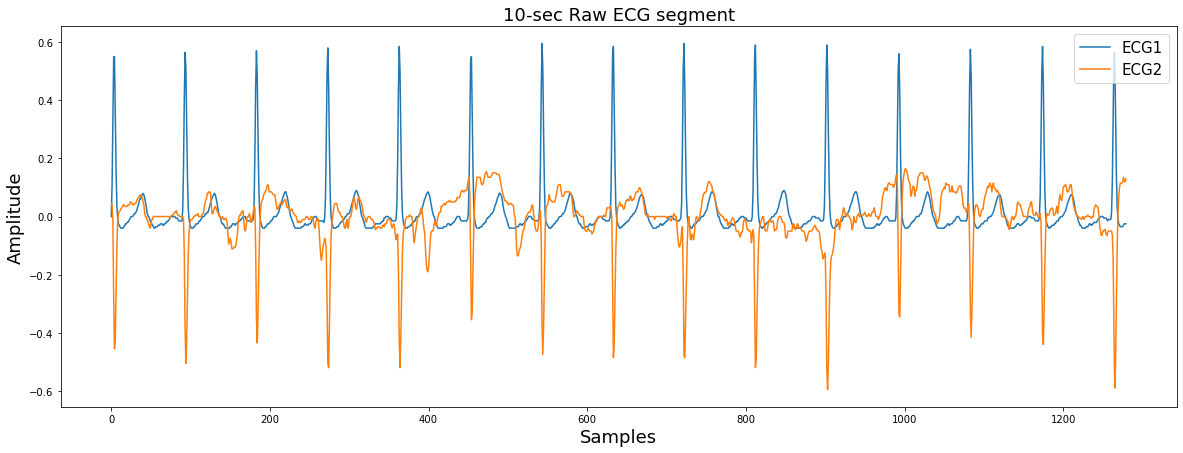

In [88]:
plt.figure(figsize=(20, 7))
plt.plot(X_train_raw[6][1500:2780])  
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec Raw ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper right", prop={'size': 15})
plt.show()

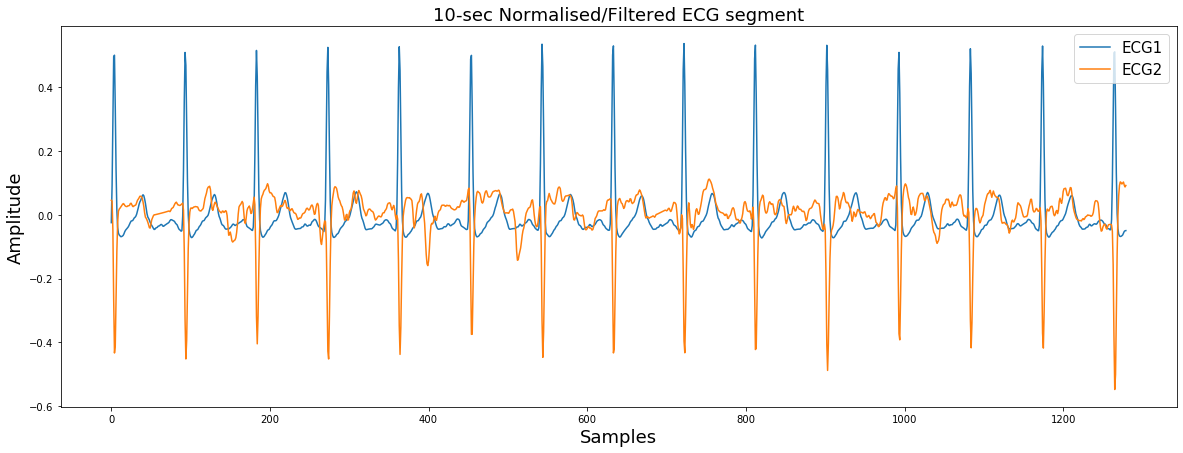

In [89]:
plt.figure(figsize=(20, 7))
plt.plot(X_train[6][1500:2780])
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec Normalised/Filtered ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper right", prop={'size': 15})
plt.show()

## 1D Convolutional Neural Network Models
### GPU is available for training the model, IT IS RECOMMENDED TO USE GPU FOR THE MODELS
For the evaluation of the models, the data was split into training, testing and validation sets as seen below. The publicly available dataset is fairly small which is why we segment the data into 5 minute segments. As a result of this, the testing and validation sets are small but I believe it is important to include a validation set in order to validate the training and see if it is overfitting, underfitting etc.

In [25]:
device_lib.list_local_devices(); 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=1)  
#70/30 train/test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
#75/25 train/val split 

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(315, 38400, 2) (315, 1)
(180, 38400, 2) (180, 1)
(105, 38400, 2) (105, 1)


# Configuration 1 - WORKS WELL - IS SMALL AND FAST - USES 5 MINUTE ECG SEGMENTS AS INPUT - BASELINE MODEL

In [131]:
# input, convolutional, subsampling(maxpool), fully connected and output
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=32, padding = 'same', kernel_initializer='normal', activation='relu', input_shape=(38400, 2)))                # Conv layer - 5 minute ECG input 64
model.add(MaxPool1D(pool_size=32))                                                                                                                      # Subsampling layer
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))                                                                              # Dense layer
model.add(MaxPool1D(pool_size=64))                                                                                                                      # Subsampling layer
model.add(Flatten())                                                                                                                                    # Flatten
model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))                                                                            # Sigmoid output, better than softmax
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 38400, 128)        8320      
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 1200, 128)         0         
_________________________________________________________________
dense_64 (Dense)             (None, 1200, 32)          4128      
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 18, 32)            0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 577       
Total params: 13,025
Trainable params: 13,025
Non-trainable params: 0
_________________________________________________

## Adam works well - Learning rate 0.0001 - Takes very long for loss to even out - slight overfitting

In [25]:
optimizer = keras.optimizers.Adam(lr=0.0001) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_val,y_val), callbacks=[es, es2])

Epoch 1/200
5/5 [==============================] - 2s 362ms/step - loss: 0.6976 - accuracy: 0.5079 - val_loss: 0.6897 - val_accuracy: 0.4952
Epoch 2/200
5/5 [==============================] - 2s 321ms/step - loss: 0.6879 - accuracy: 0.5048 - val_loss: 0.6833 - val_accuracy: 0.4952
Epoch 3/200
5/5 [==============================] - 2s 322ms/step - loss: 0.6801 - accuracy: 0.5016 - val_loss: 0.6782 - val_accuracy: 0.5714
Epoch 4/200
5/5 [==============================] - 2s 323ms/step - loss: 0.6732 - accuracy: 0.5841 - val_loss: 0.6736 - val_accuracy: 0.6286
Epoch 5/200
5/5 [==============================] - 2s 322ms/step - loss: 0.6679 - accuracy: 0.6127 - val_loss: 0.6690 - val_accuracy: 0.6476
Epoch 6/200
5/5 [==============================] - 2s 323ms/step - loss: 0.6629 - accuracy: 0.6413 - val_loss: 0.6645 - val_accuracy: 0.7048
Epoch 7/200
5/5 [==============================] - 2s 323ms/step - loss: 0.6558 - accuracy: 0.6508 - val_loss: 0.6600 - val_accuracy: 0.7238
Epoch 8/200
5

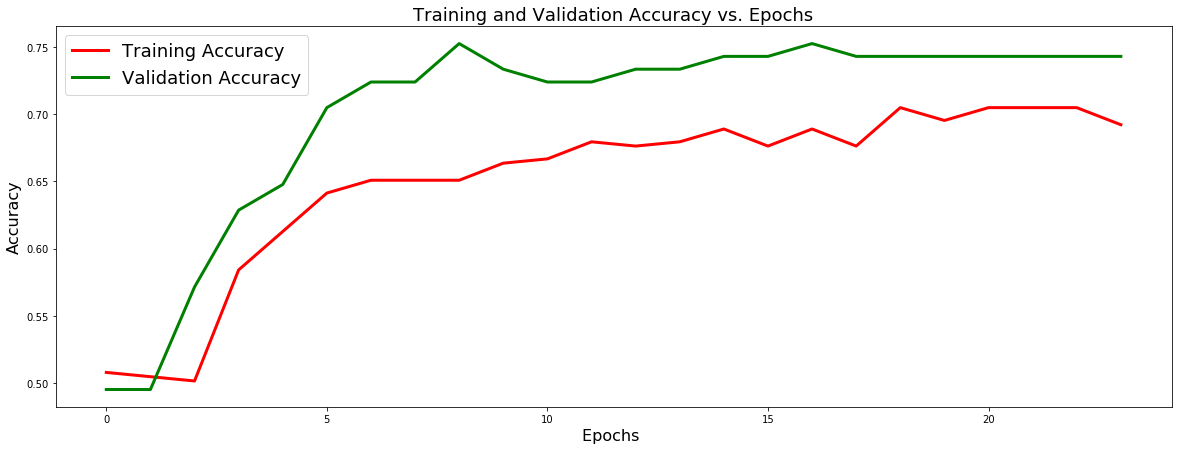

In [26]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

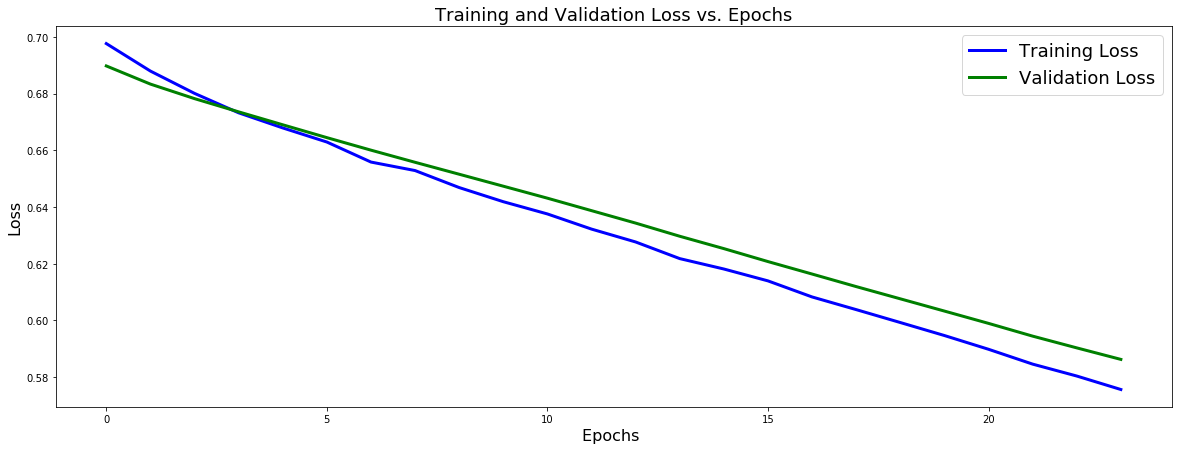

In [27]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Adam - Lowered learning rate to 0.001 - slight overfitting - Testing many times

In [121]:
optimizer = keras.optimizers.Adam(lr=0.001) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val,y_val), callbacks=[es, es2])

Epoch 1/40
5/5 [==============================] - 1s 293ms/step - loss: 0.6935 - accuracy: 0.5238 - val_loss: 0.6755 - val_accuracy: 0.4857
Epoch 2/40
5/5 [==============================] - 1s 250ms/step - loss: 0.6679 - accuracy: 0.6413 - val_loss: 0.6513 - val_accuracy: 0.7048
Epoch 3/40
5/5 [==============================] - 1s 247ms/step - loss: 0.6409 - accuracy: 0.6635 - val_loss: 0.6222 - val_accuracy: 0.7333
Epoch 4/40
5/5 [==============================] - 1s 249ms/step - loss: 0.6107 - accuracy: 0.7302 - val_loss: 0.5911 - val_accuracy: 0.7143
Epoch 5/40
5/5 [==============================] - 1s 245ms/step - loss: 0.5745 - accuracy: 0.6952 - val_loss: 0.5569 - val_accuracy: 0.7333
Epoch 6/40
5/5 [==============================] - 1s 243ms/step - loss: 0.5452 - accuracy: 0.7048 - val_loss: 0.5214 - val_accuracy: 0.7429
Epoch 7/40
5/5 [==============================] - 1s 250ms/step - loss: 0.5127 - accuracy: 0.7143 - val_loss: 0.4928 - val_accuracy: 0.7429
Epoch 8/40
5/5 [====

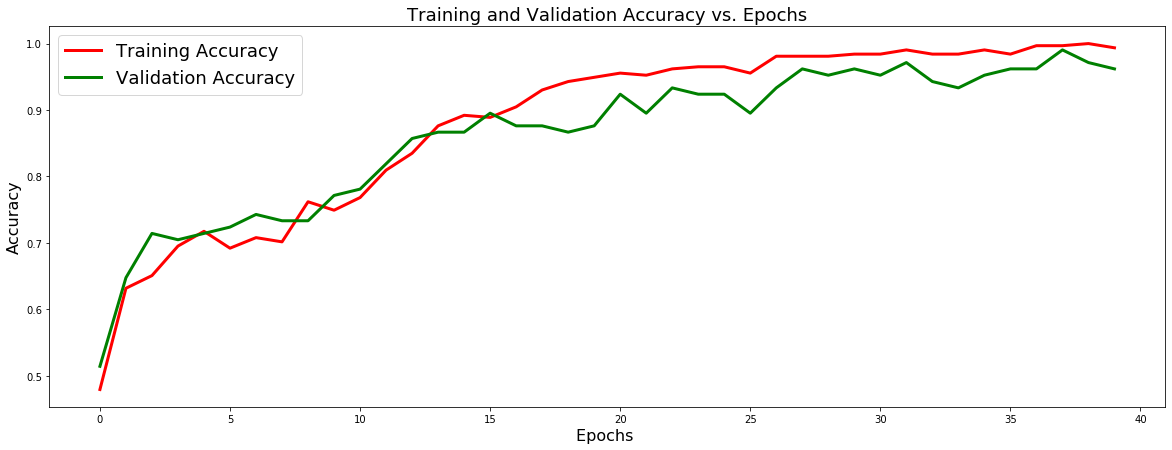

In [87]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

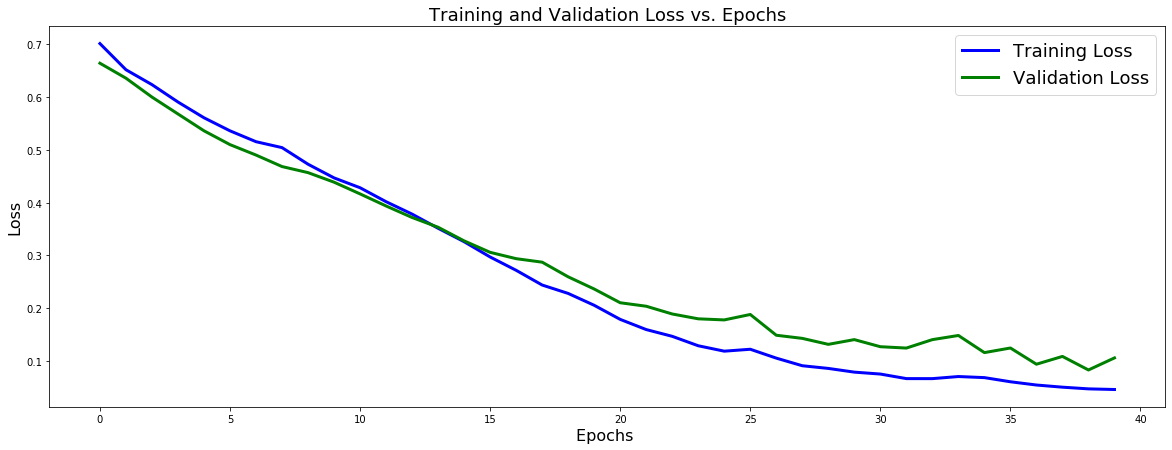

In [88]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

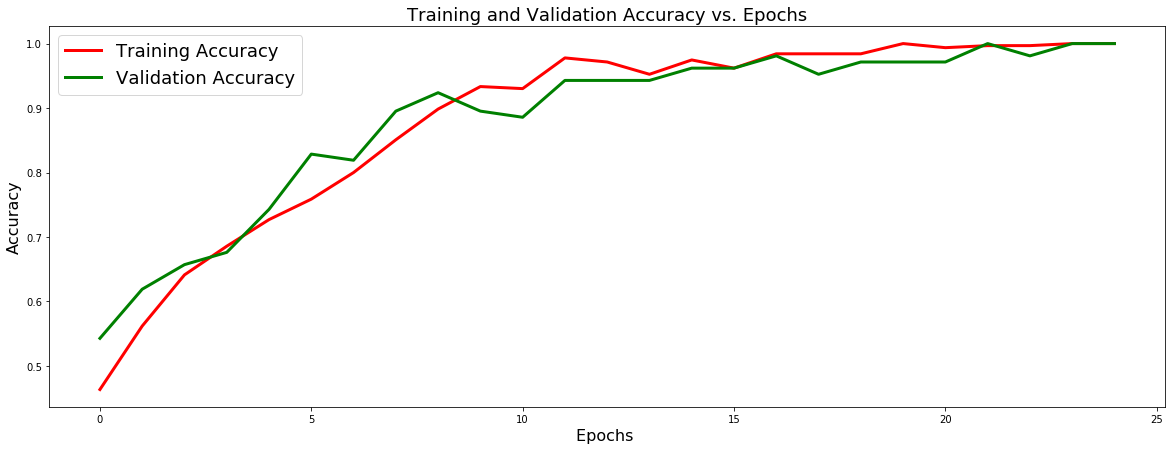

In [22]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

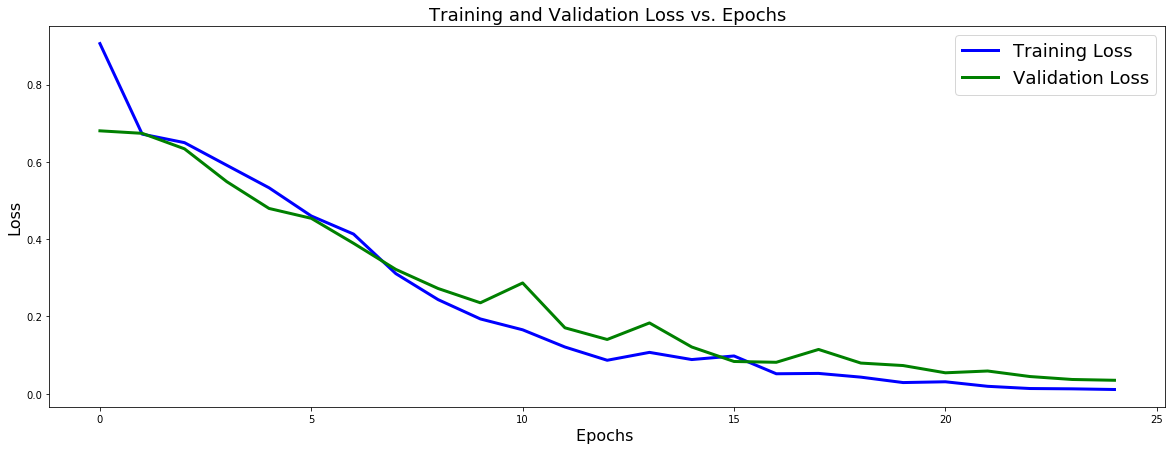

In [23]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

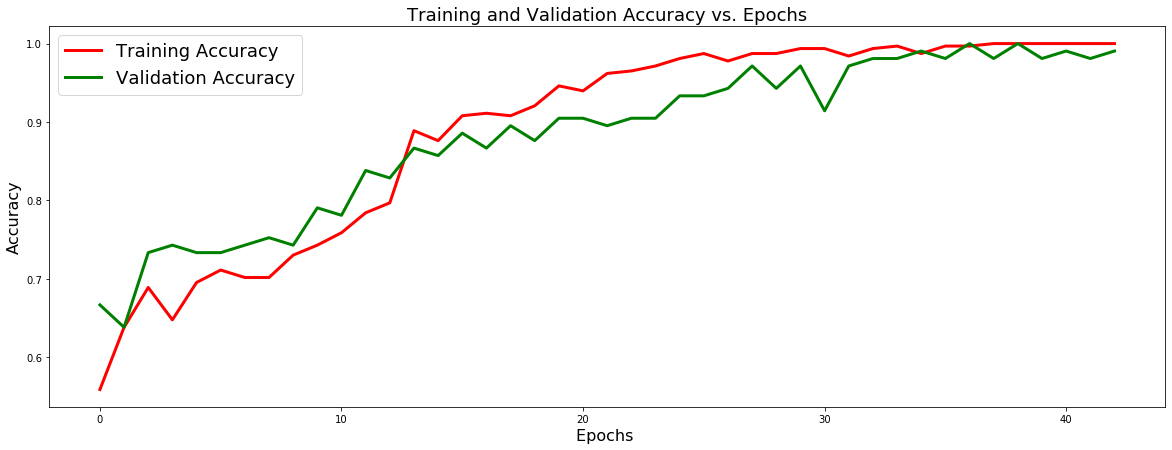

In [44]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

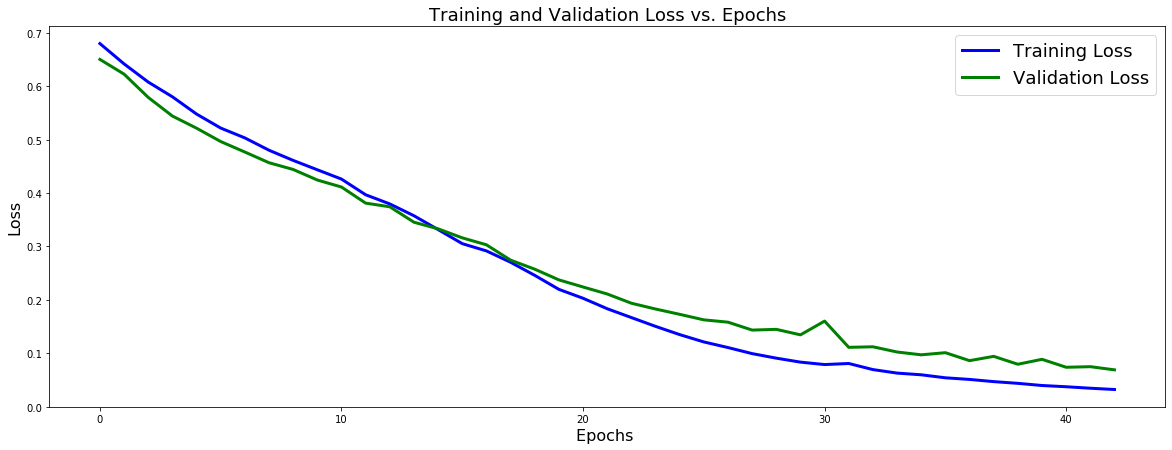

In [45]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

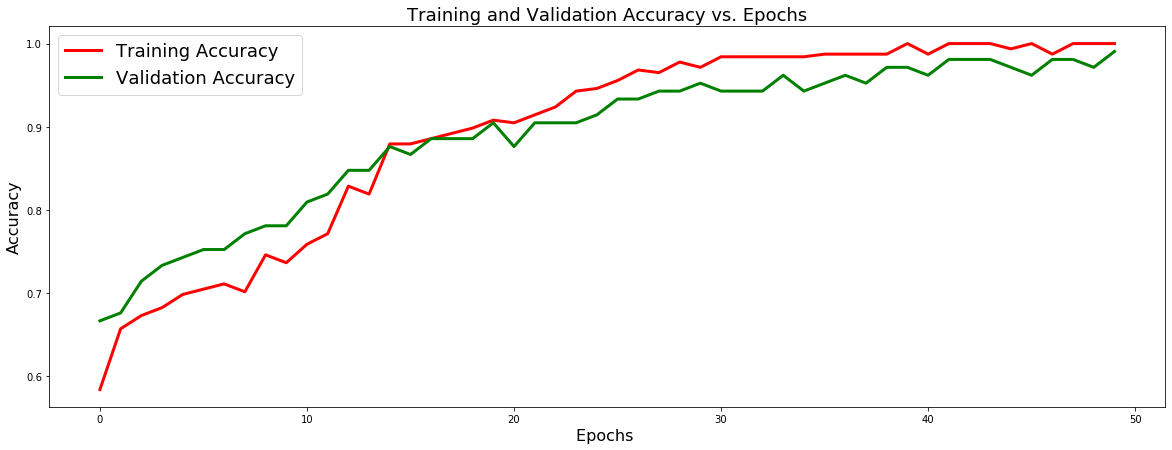

In [55]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

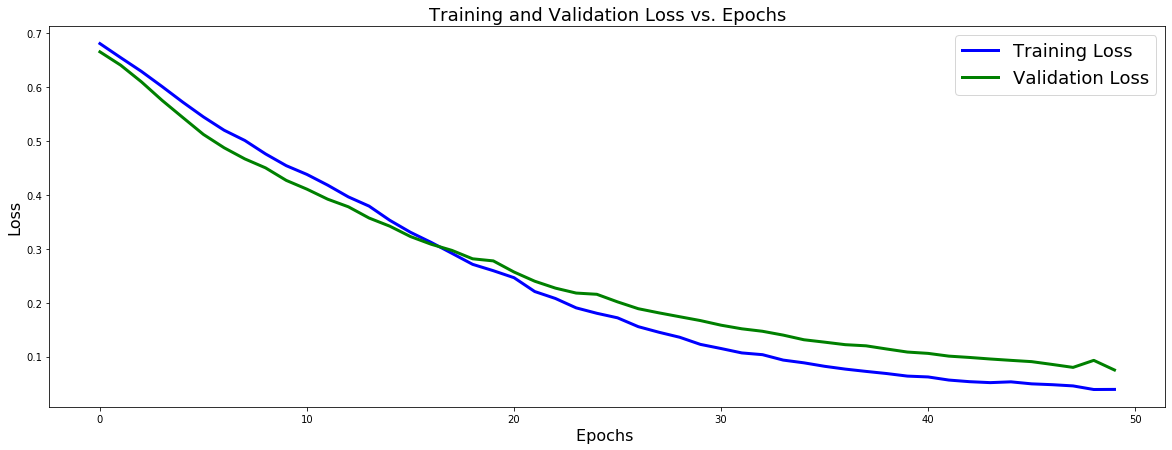

In [56]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

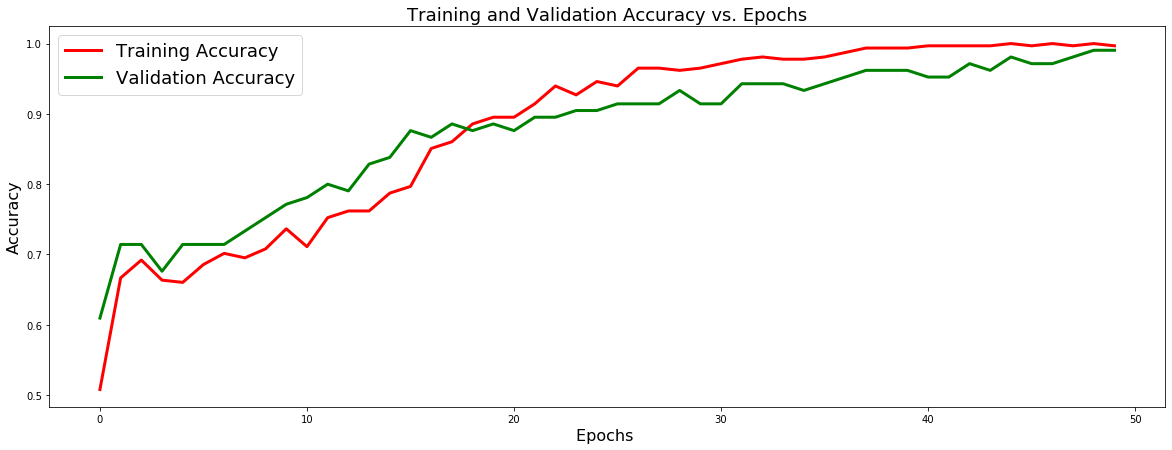

In [86]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

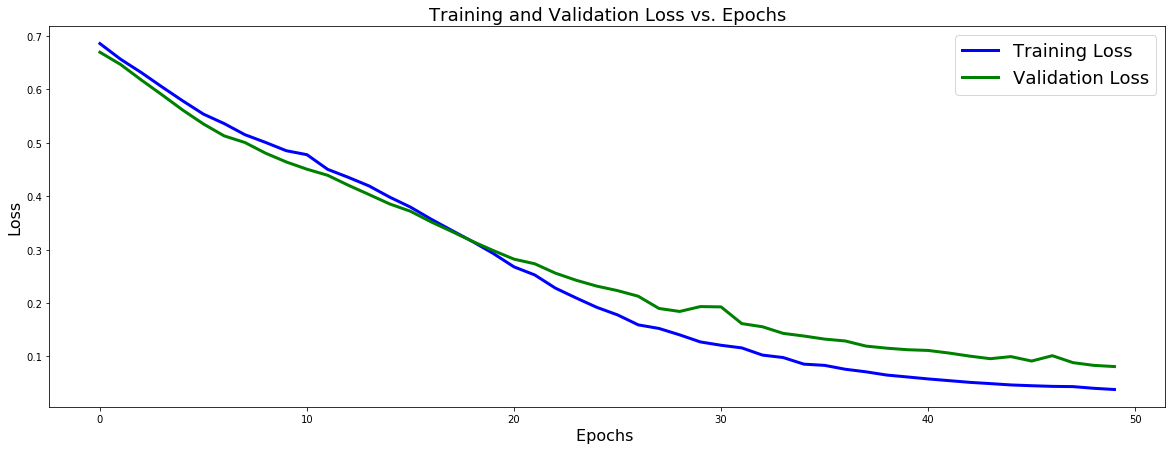

In [87]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Adam - learning rate 0.01 - Not bad

In [92]:
optimizer = keras.optimizers.Adam(lr=0.01) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val,y_val), callbacks=[es, es2])

Epoch 1/20
5/5 [==============================] - 1s 279ms/step - loss: 0.8441 - accuracy: 0.4984 - val_loss: 0.6599 - val_accuracy: 0.7429
Epoch 2/20
5/5 [==============================] - 1s 246ms/step - loss: 0.6305 - accuracy: 0.6794 - val_loss: 0.5699 - val_accuracy: 0.6286
Epoch 3/20
5/5 [==============================] - 1s 241ms/step - loss: 0.5563 - accuracy: 0.6603 - val_loss: 0.4932 - val_accuracy: 0.7238
Epoch 4/20
5/5 [==============================] - 1s 242ms/step - loss: 0.5122 - accuracy: 0.7079 - val_loss: 0.4318 - val_accuracy: 0.7810
Epoch 5/20
5/5 [==============================] - 1s 246ms/step - loss: 0.4611 - accuracy: 0.7683 - val_loss: 0.4480 - val_accuracy: 0.7048
Epoch 6/20
5/5 [==============================] - 1s 241ms/step - loss: 0.4625 - accuracy: 0.7270 - val_loss: 0.4235 - val_accuracy: 0.7905
Epoch 7/20
5/5 [==============================] - 1s 216ms/step - loss: 0.3849 - accuracy: 0.8159 - val_loss: 0.2965 - val_accuracy: 0.8952
Epoch 8/20
5/5 [====

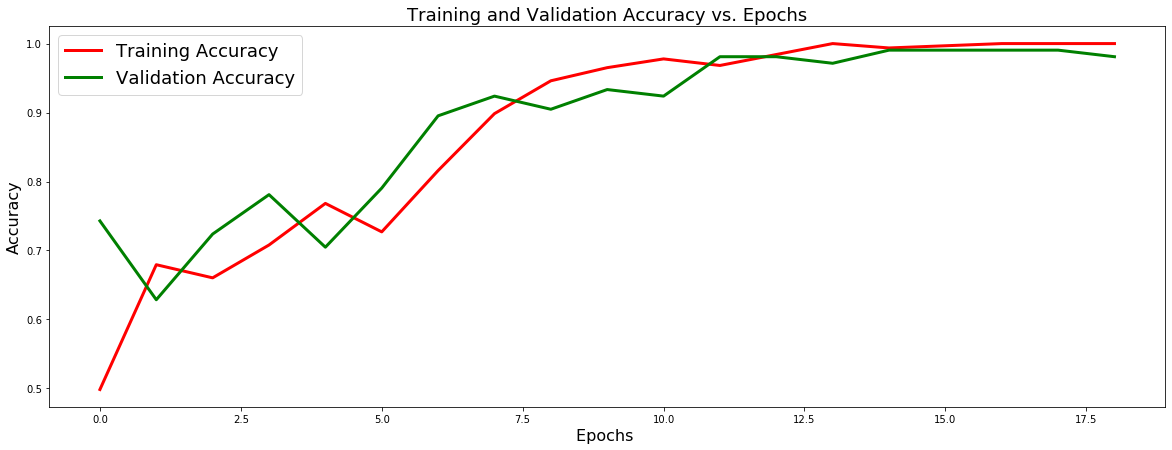

In [93]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

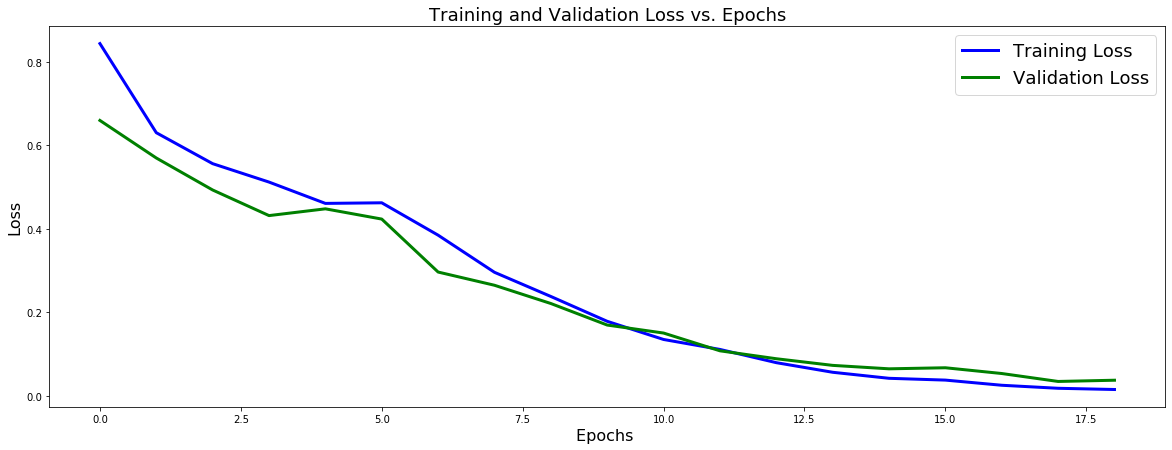

In [94]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

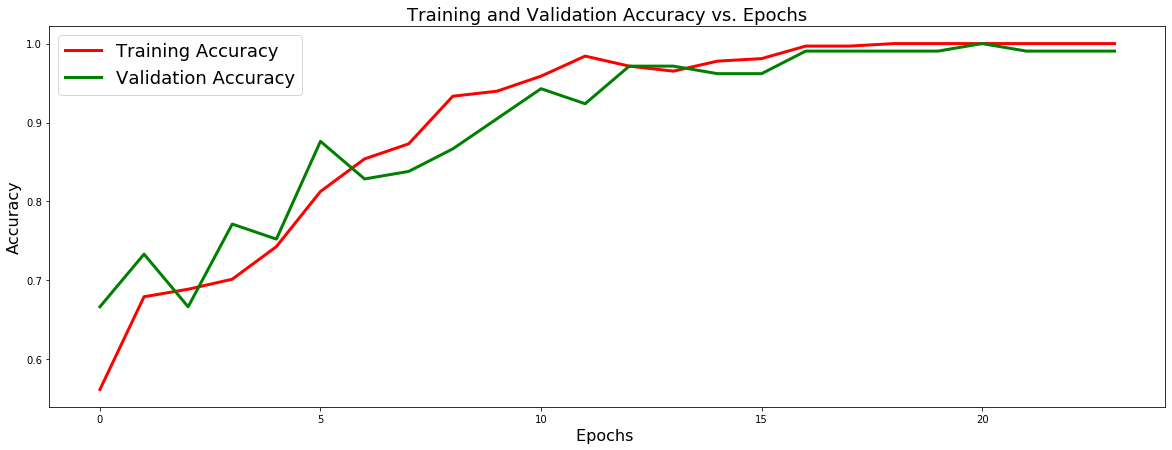

In [51]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

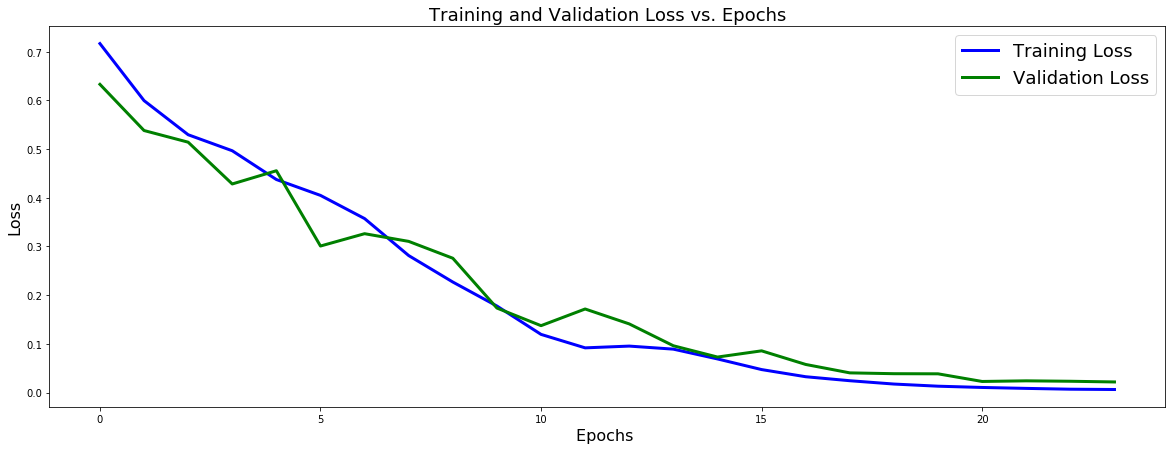

In [52]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Adam - learning rate 0.09

In [132]:
optimizer = keras.optimizers.Adam(lr=0.09) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=6)
history = model.fit(X_train, y_train, batch_size=64, epochs=300, validation_data=(X_val,y_val), callbacks=[es, es2])

Epoch 1/50
5/5 [==============================] - 1s 285ms/step - loss: 41.7272 - accuracy: 0.5397 - val_loss: 0.7374 - val_accuracy: 0.4190
Epoch 2/50
5/5 [==============================] - 1s 236ms/step - loss: 0.7014 - accuracy: 0.5556 - val_loss: 0.6167 - val_accuracy: 0.6571
Epoch 3/50
5/5 [==============================] - 1s 238ms/step - loss: 0.6582 - accuracy: 0.6825 - val_loss: 0.5297 - val_accuracy: 0.7333
Epoch 4/50
5/5 [==============================] - 1s 240ms/step - loss: 0.5693 - accuracy: 0.7016 - val_loss: 0.5698 - val_accuracy: 0.7429
Epoch 5/50
5/5 [==============================] - 1s 239ms/step - loss: 0.5324 - accuracy: 0.7429 - val_loss: 0.5655 - val_accuracy: 0.6952
Epoch 6/50
5/5 [==============================] - 1s 224ms/step - loss: 0.5259 - accuracy: 0.7397 - val_loss: 0.4153 - val_accuracy: 0.7905
Epoch 7/50
5/5 [==============================] - 1s 231ms/step - loss: 0.3884 - accuracy: 0.8032 - val_loss: 0.4150 - val_accuracy: 0.8286
Epoch 8/50
5/5 [===

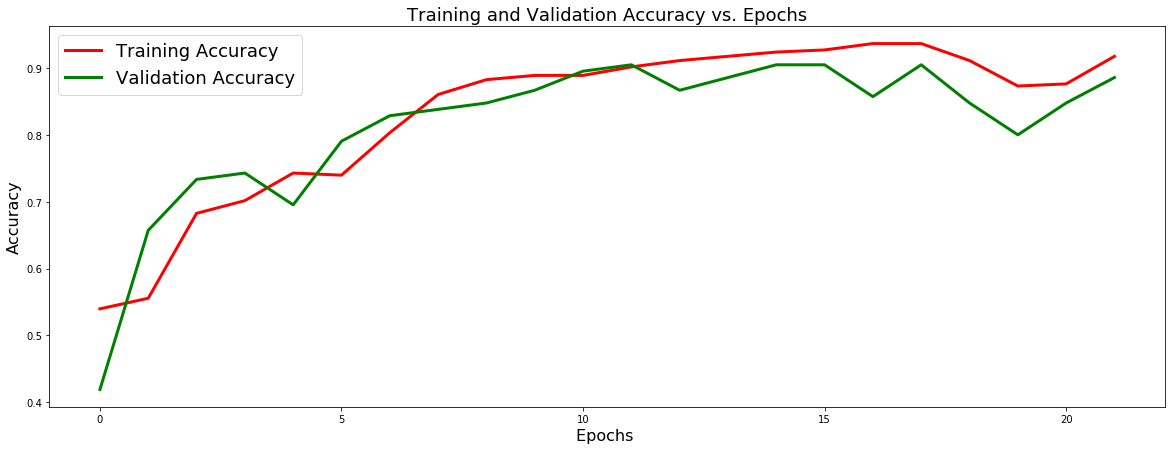

In [133]:
plt.figure(figsize=(20, 7))                                                  
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

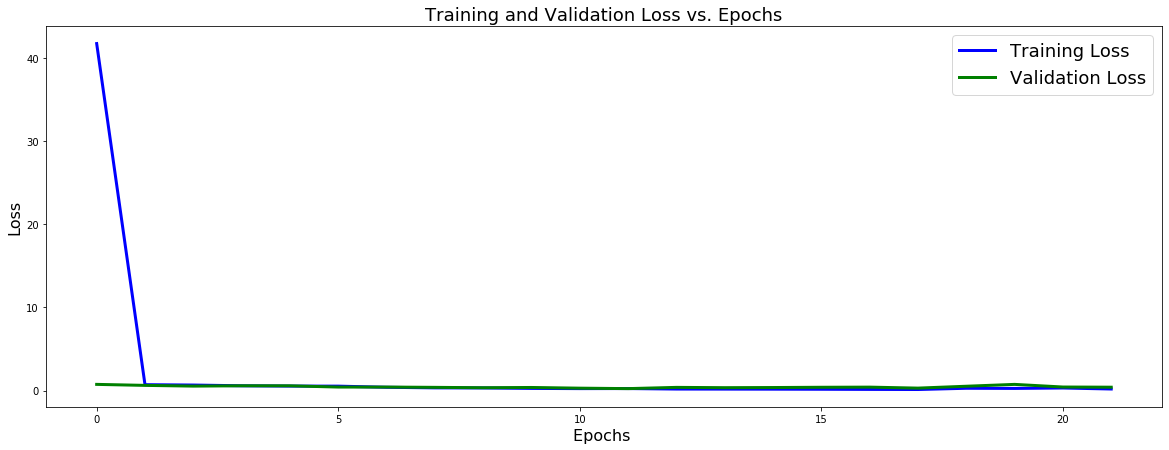

In [134]:
plt.figure(figsize=(20, 7))                                                                     
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

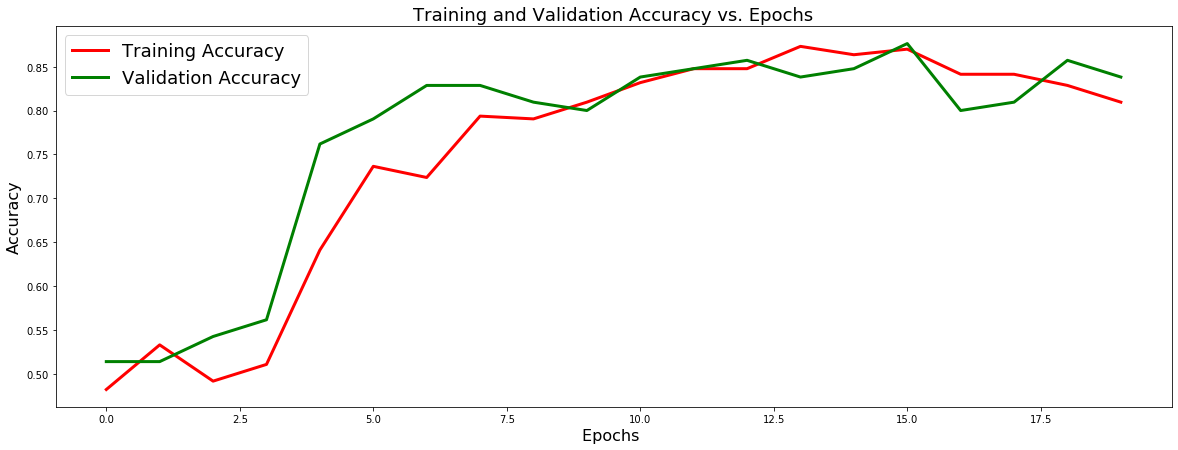

In [118]:
plt.figure(figsize=(20, 7))                                                  
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

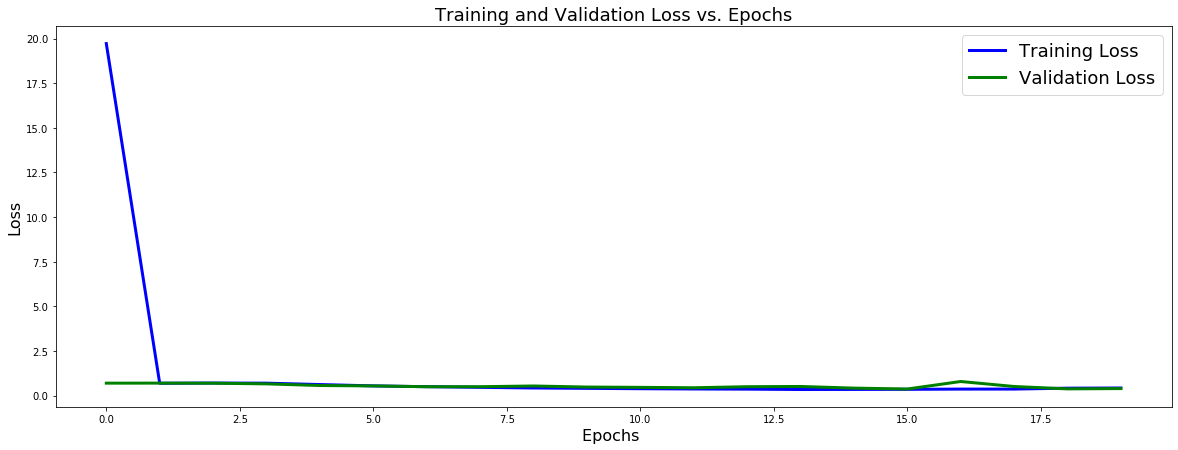

In [119]:
plt.figure(figsize=(20, 7))                                                                     
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

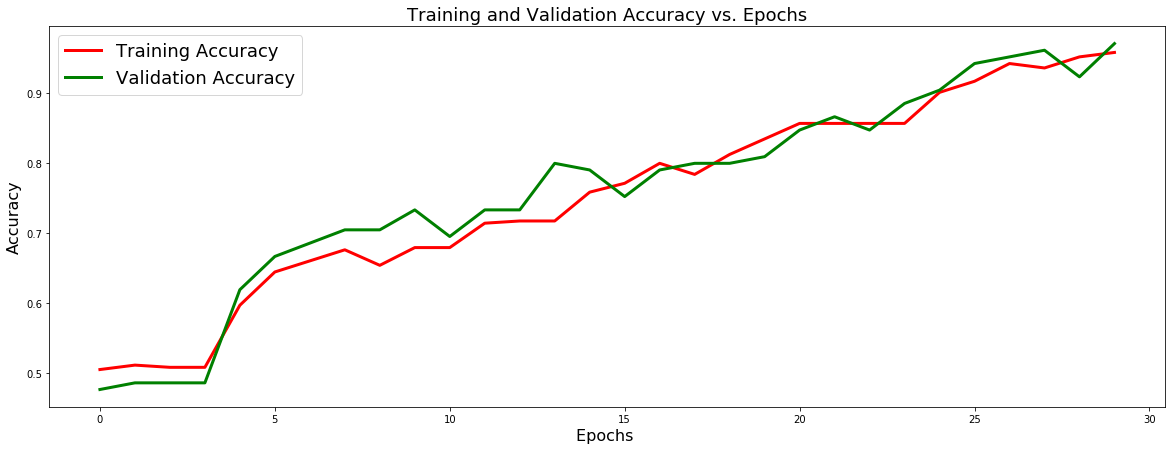

In [105]:
plt.figure(figsize=(20, 7))                                                  
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

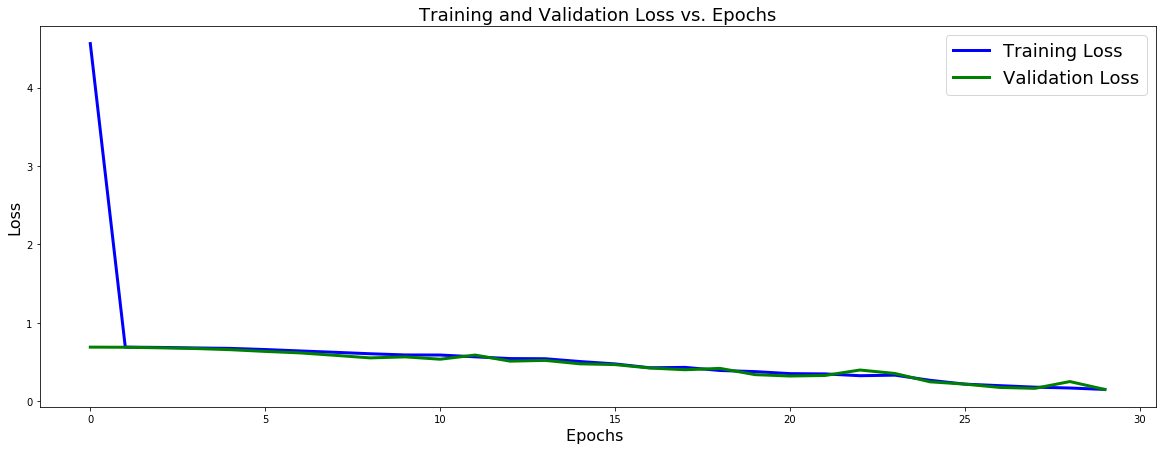

In [106]:
plt.figure(figsize=(20, 7))                                                                     
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## SGD - not as good as Adam - Tested many times with different parameters

In [83]:
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val,y_val), callbacks=[es, es2])

Epoch 1/50
5/5 [==============================] - 1s 283ms/step - loss: 0.6869 - accuracy: 0.4984 - val_loss: 0.6607 - val_accuracy: 0.5619
Epoch 2/50
5/5 [==============================] - 1s 249ms/step - loss: 0.6292 - accuracy: 0.6286 - val_loss: 0.5828 - val_accuracy: 0.6381
Epoch 3/50
5/5 [==============================] - 1s 247ms/step - loss: 0.5815 - accuracy: 0.6317 - val_loss: 0.7176 - val_accuracy: 0.6381
Epoch 4/50
5/5 [==============================] - 1s 246ms/step - loss: 0.6405 - accuracy: 0.5810 - val_loss: 0.6102 - val_accuracy: 0.6095
Epoch 5/50
5/5 [==============================] - 1s 242ms/step - loss: 0.5273 - accuracy: 0.6698 - val_loss: 0.4558 - val_accuracy: 0.7905
Epoch 6/50
5/5 [==============================] - 1s 238ms/step - loss: 0.4625 - accuracy: 0.7175 - val_loss: 0.4253 - val_accuracy: 0.7524
Epoch 7/50
5/5 [==============================] - 1s 241ms/step - loss: 0.3807 - accuracy: 0.8317 - val_loss: 0.4549 - val_accuracy: 0.8381
Epoch 8/50
5/5 [====

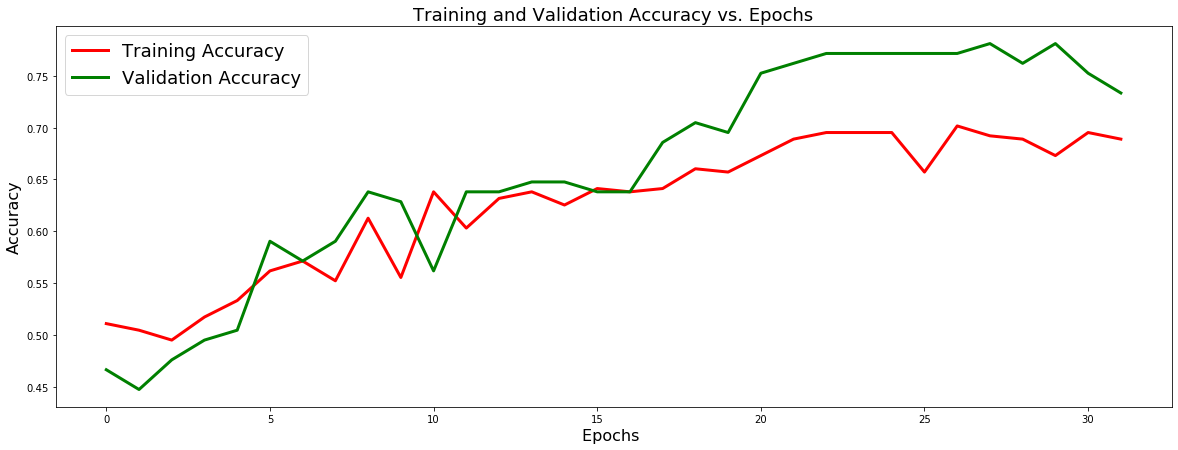

In [72]:
plt.figure(figsize=(20, 7))                                                  # lr = 0.001 momentum =0.99
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

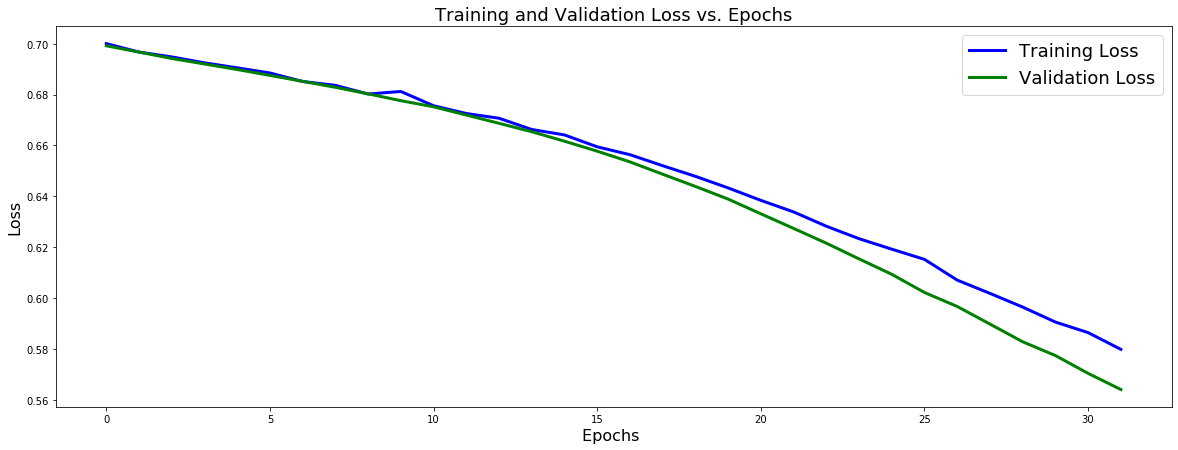

In [73]:
plt.figure(figsize=(20, 7))                                                                     # lr = 0.001 momentum =0.99
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

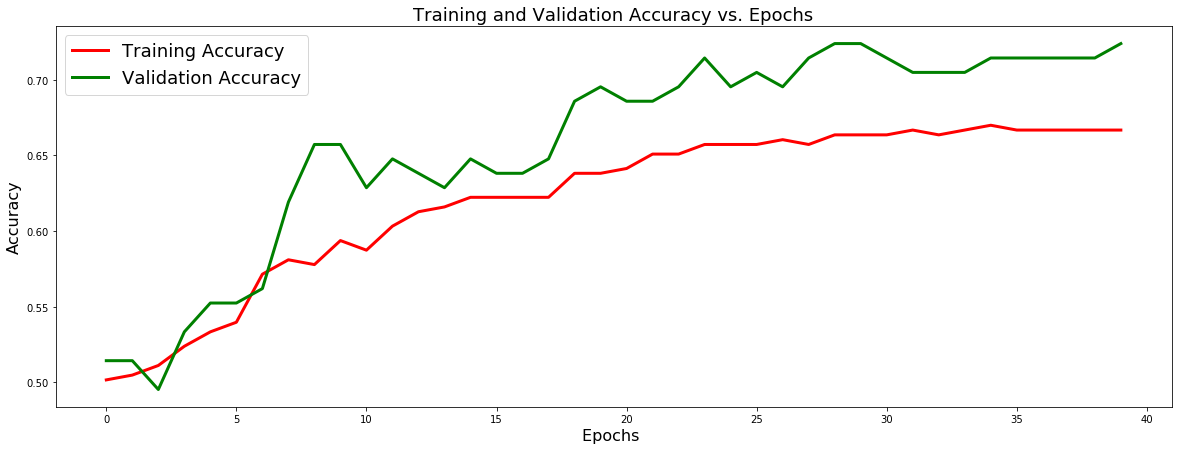

In [58]:
plt.figure(figsize=(20, 7))                                                                             # lr = 0.001 momentum =0.9
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

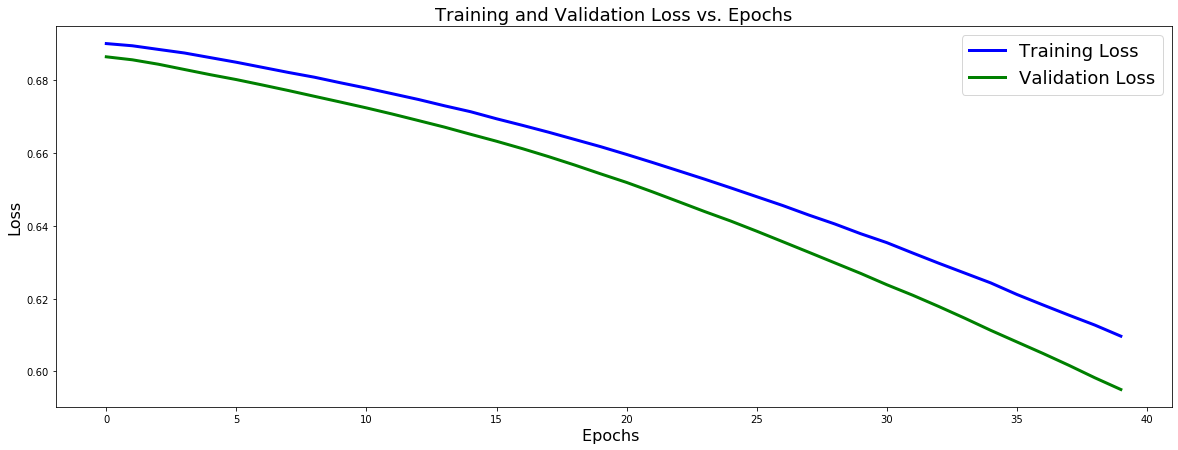

In [59]:
plt.figure(figsize=(20, 7))                                                                 # lr = 0.001 momentum =0.9
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

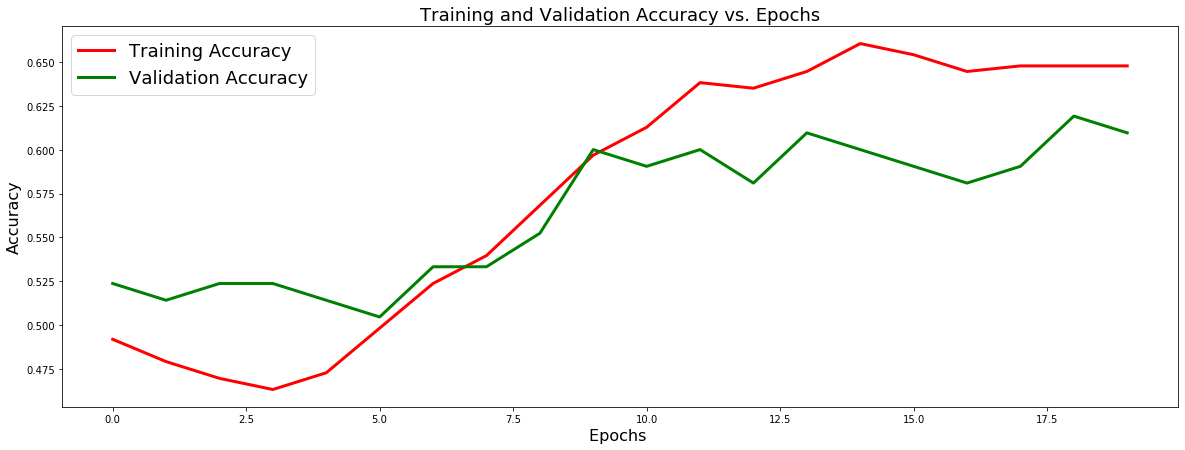

In [54]:
plt.figure(figsize=(20, 7))                                                         # lr = 0.001 momentum =0.5
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

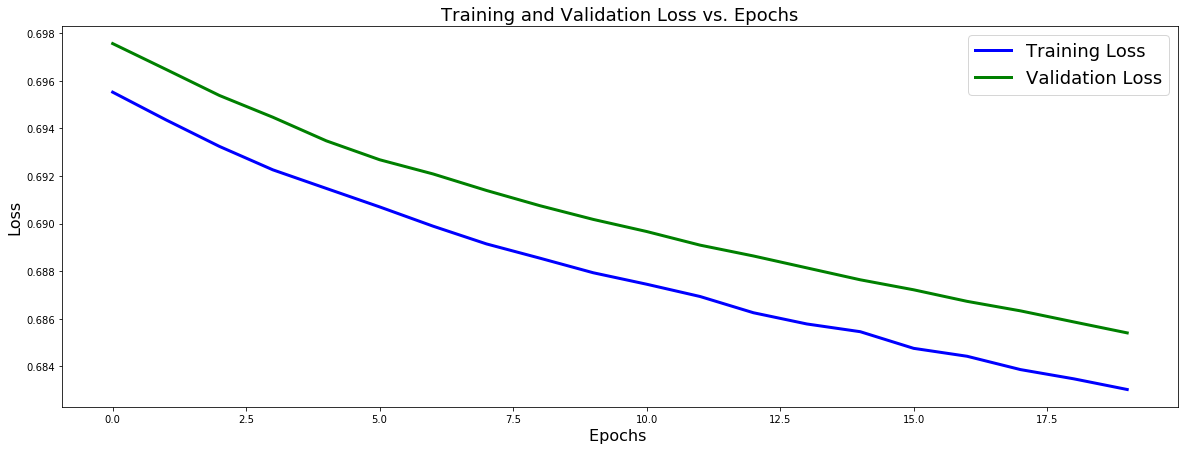

In [55]:
plt.figure(figsize=(20, 7))                                                             # lr = 0.001 momentum =0.5
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Evaluating on the model using Adam with LR = 0.001

In [70]:
y_pred = model.predict(x=X_test, batch_size=64)

In [71]:
y_pred = np.round(y_pred)
print(y_pred.shape)

(180, 1)


In [72]:
np.count_nonzero(y_pred == 1)

94

In [73]:
for i in range(20):
	print("Predicted=%s, Actual=%s" % (y_pred[i], y_test[i]))

Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]


In [74]:
accuracy = Accuracy()
accuracy.update_state(y_test, y_pred)
accuracy.result().numpy()

0.98333335

In [75]:
calculated_accuracy = sum(y_pred == y_test)/len(y_pred)
print(calculated_accuracy)

[0.98333333]


In [76]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

Confusion matrix, without normalization
[[86  3]
 [ 0 91]]


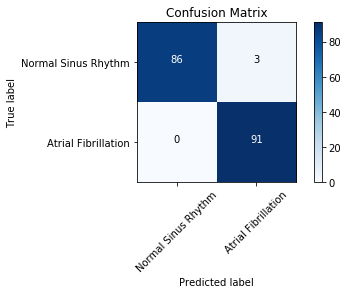

In [77]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        89
           1       0.97      1.00      0.98        91

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



In [78]:
model_path = os.path.join('models', 'CNN2-Small')
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models\CNN2-Small\assets
Saved trained model at models\CNN2-Small 


# Configuration 2 - ONLY WORKS WELL WITH 1 MINUTE ECG SEGMENTS - ALSO REQUIRES MORE PROCESSING POWER 

In [144]:
# Load normalised/filtered ECG training data - Use 5 min segments for first CNN model, 1 min for second CNN
X_train, y_train = load_label_segment(train_folder, '1 min', True) # '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train.shape, y_train.shape)

(3000, 7680, 2) (3000, 1)


In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=30)  
#70/30 train/test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=30)
#75/25 train/val split 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1575, 7680, 2) (1575, 1)
(900, 7680, 2) (900, 1)
(525, 7680, 2) (525, 1)


In [206]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu', input_shape=(7680, 2))) # Conv layer taking 1 minute segments input 7680
model.add(BatchNormalization())                                                                                                       # Adding normalisation
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                        # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=64, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                        # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.2))                                                                                                               # Dropout, prevents overfitting (50%)
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.2))                                                                                                               # Dropout (50%)
model.add(Conv1D(filters=512, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.2))                                                                                                               # Dropout (50%)
model.add(Conv1D(filters=512, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(Flatten())                                                                                                                  # Flatten
model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))                                                           # FC Layer, 128 neurons
model.add(Dropout(0.50))                                                                                                               # Dropout (50%)
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))                                                            # FC layer, 32 neurons
model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))                                                          # Output layer, binary classification
model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_155 (Conv1D)          (None, 7680, 32)          352       
_________________________________________________________________
batch_normalization_10 (Batc (None, 7680, 32)          128       
_________________________________________________________________
max_pooling1d_174 (MaxPoolin (None, 3840, 32)          0         
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 3840, 32)          5152      
_________________________________________________________________
max_pooling1d_175 (MaxPoolin (None, 1920, 32)          0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 1920, 64)          10304     
_________________________________________________________________
max_pooling1d_176 (MaxPoolin (None, 960, 64)         

## TRYING WITH SGD OPTIMIZER - Not great

In [164]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history3 = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val,y_val), callbacks=[es, es2])

Epoch 1/40
50/50 [==============================] - 3s 51ms/step - loss: 0.7101 - accuracy: 0.4857 - val_loss: 0.6931 - val_accuracy: 0.5124
Epoch 2/40
50/50 [==============================] - 2s 41ms/step - loss: 0.6912 - accuracy: 0.5143 - val_loss: 0.6929 - val_accuracy: 0.5048
Epoch 3/40
50/50 [==============================] - 2s 42ms/step - loss: 0.6867 - accuracy: 0.5397 - val_loss: 0.6919 - val_accuracy: 0.5429
Epoch 4/40
50/50 [==============================] - 2s 43ms/step - loss: 0.6835 - accuracy: 0.5511 - val_loss: 0.6906 - val_accuracy: 0.5257
Epoch 5/40
50/50 [==============================] - 2s 46ms/step - loss: 0.6672 - accuracy: 0.6025 - val_loss: 0.6897 - val_accuracy: 0.5238
Epoch 6/40
50/50 [==============================] - 2s 44ms/step - loss: 0.6321 - accuracy: 0.6400 - val_loss: 0.6595 - val_accuracy: 0.6514
Epoch 7/40
50/50 [==============================] - 2s 43ms/step - loss: 0.5805 - accuracy: 0.6768 - val_loss: 0.6220 - val_accuracy: 0.7524
Epoch 8/40
50

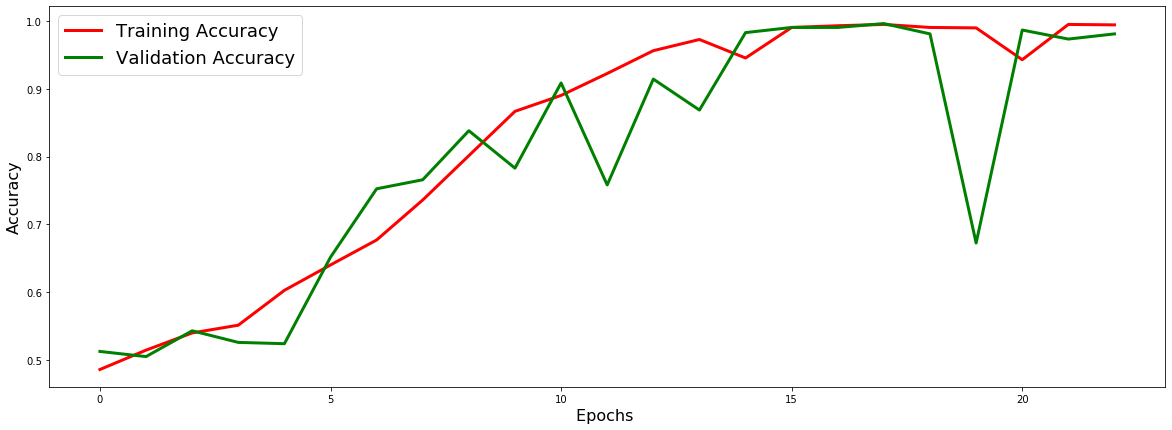

In [165]:
plt.figure(figsize=(20, 7))                                                                         #lr=0.001, momentum=0.9
plt.plot(history3.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

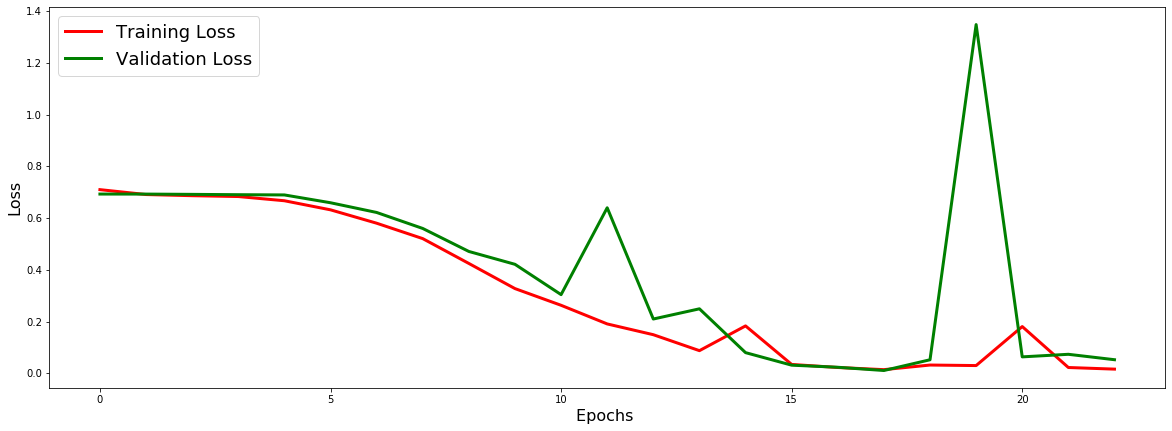

In [166]:
plt.figure(figsize=(20, 7))                                                                            # lr=0.001, momentum=0.9
plt.plot(history3.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history3.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

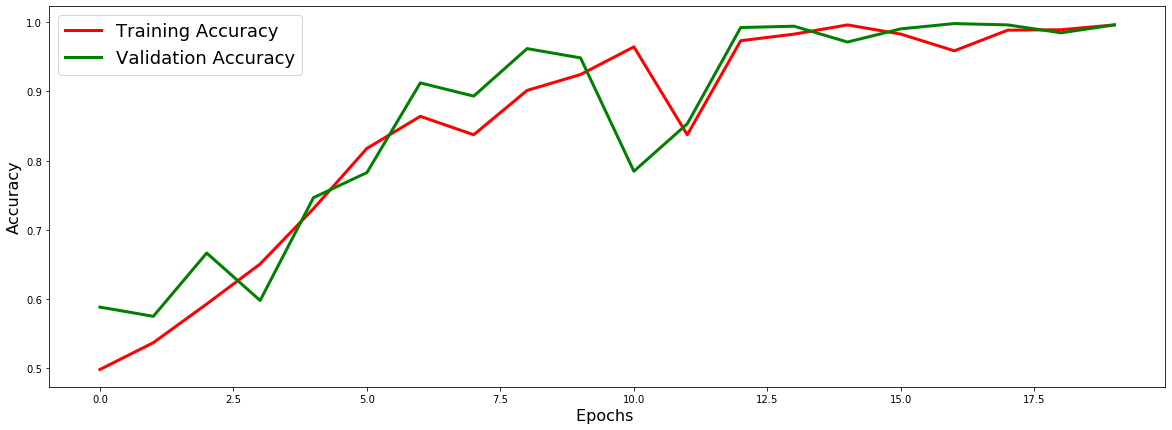

In [148]:
plt.figure(figsize=(20, 7))                                                                         #lr=0.001, momentum=0.9
plt.plot(history3.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

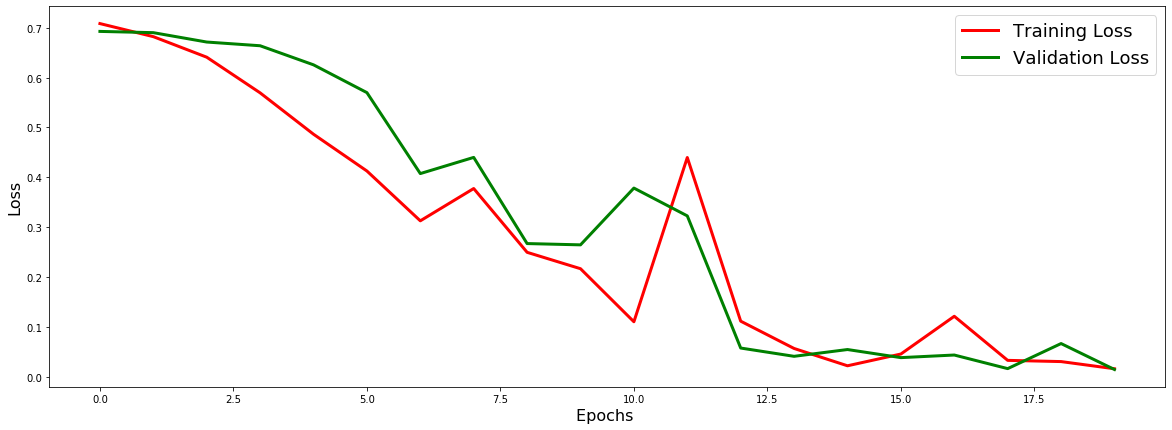

In [149]:
plt.figure(figsize=(20, 7))
plt.plot(history3.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history3.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## TRYING ADAM - LR = 0.001 - better

In [199]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history4 = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val,y_val), callbacks=[es, es2])

Epoch 1/40
50/50 [==============================] - 3s 61ms/step - loss: 0.7002 - accuracy: 0.4908 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 2/40
50/50 [==============================] - 2s 44ms/step - loss: 0.5835 - accuracy: 0.6768 - val_loss: 0.7433 - val_accuracy: 0.4857
Epoch 3/40
50/50 [==============================] - 2s 44ms/step - loss: 0.6979 - accuracy: 0.5003 - val_loss: 0.6930 - val_accuracy: 0.4857
Epoch 4/40
50/50 [==============================] - 2s 44ms/step - loss: 0.6266 - accuracy: 0.5537 - val_loss: 0.6963 - val_accuracy: 0.5143
Epoch 5/40
50/50 [==============================] - 2s 45ms/step - loss: 0.6104 - accuracy: 0.6190 - val_loss: 0.6609 - val_accuracy: 0.5848
Epoch 6/40
50/50 [==============================] - 2s 44ms/step - loss: 0.5638 - accuracy: 0.6654 - val_loss: 0.6339 - val_accuracy: 0.6324
Epoch 7/40
50/50 [==============================] - 2s 44ms/step - loss: 0.4676 - accuracy: 0.7575 - val_loss: 0.5496 - val_accuracy: 0.7657
Epoch 8/40
50

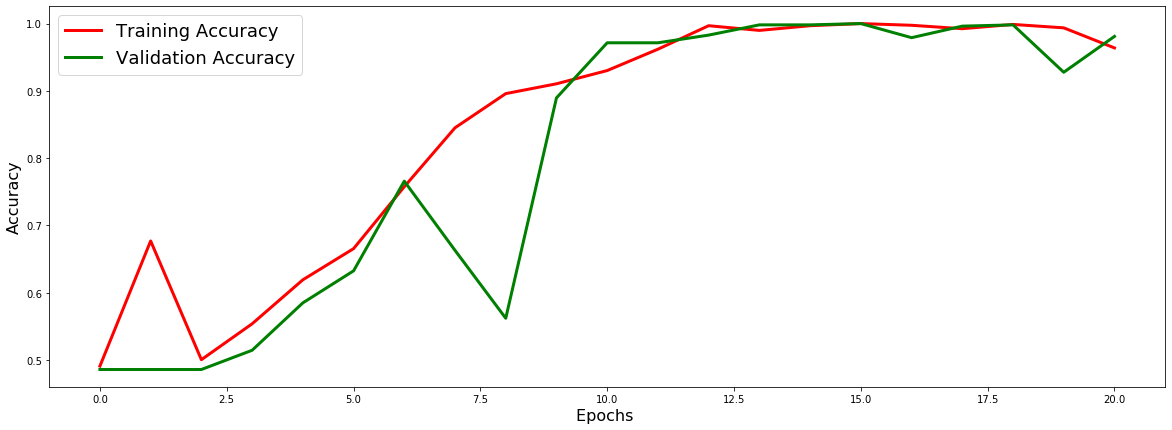

In [200]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

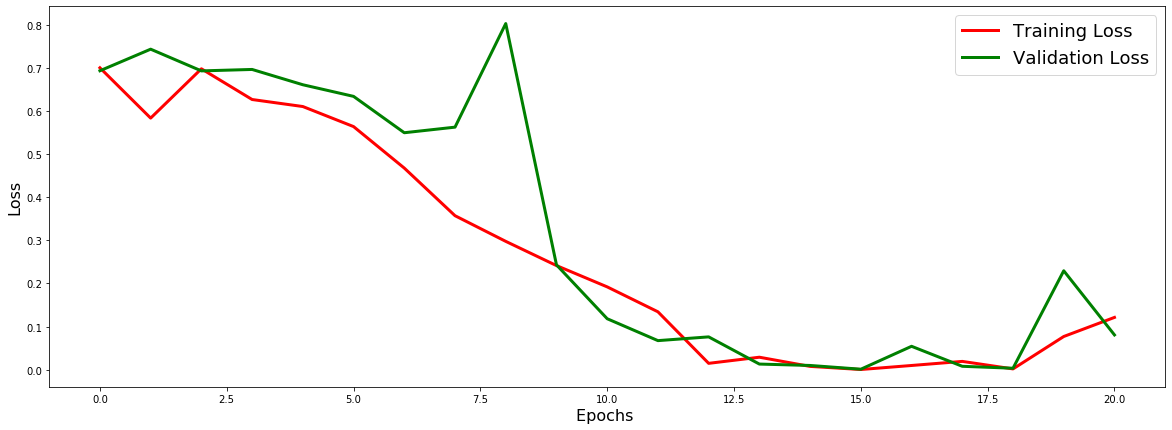

In [201]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## TRYING ADAM - LR = 0.0001 - better

In [207]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es2 = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
history4 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val,y_val), callbacks=[es, es2])

Epoch 1/20
50/50 [==============================] - 3s 52ms/step - loss: 0.7038 - accuracy: 0.5168 - val_loss: 0.6920 - val_accuracy: 0.6038
Epoch 2/20
50/50 [==============================] - 2s 45ms/step - loss: 0.6649 - accuracy: 0.5987 - val_loss: 0.6810 - val_accuracy: 0.6667
Epoch 3/20
50/50 [==============================] - 2s 46ms/step - loss: 0.5459 - accuracy: 0.6946 - val_loss: 0.6418 - val_accuracy: 0.7562
Epoch 4/20
50/50 [==============================] - 2s 46ms/step - loss: 0.3820 - accuracy: 0.8438 - val_loss: 0.5931 - val_accuracy: 0.6648
Epoch 5/20
50/50 [==============================] - 2s 45ms/step - loss: 0.3261 - accuracy: 0.8571 - val_loss: 0.5366 - val_accuracy: 0.8800
Epoch 6/20
50/50 [==============================] - 2s 45ms/step - loss: 0.2149 - accuracy: 0.9181 - val_loss: 0.3909 - val_accuracy: 0.9143
Epoch 7/20
50/50 [==============================] - 2s 44ms/step - loss: 0.0985 - accuracy: 0.9702 - val_loss: 0.2302 - val_accuracy: 0.9600
Epoch 8/20
50

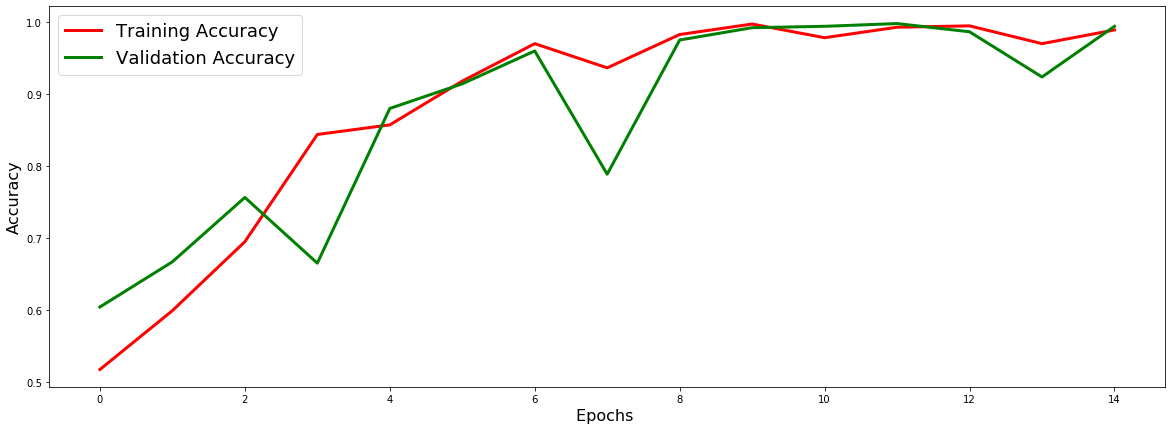

In [208]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

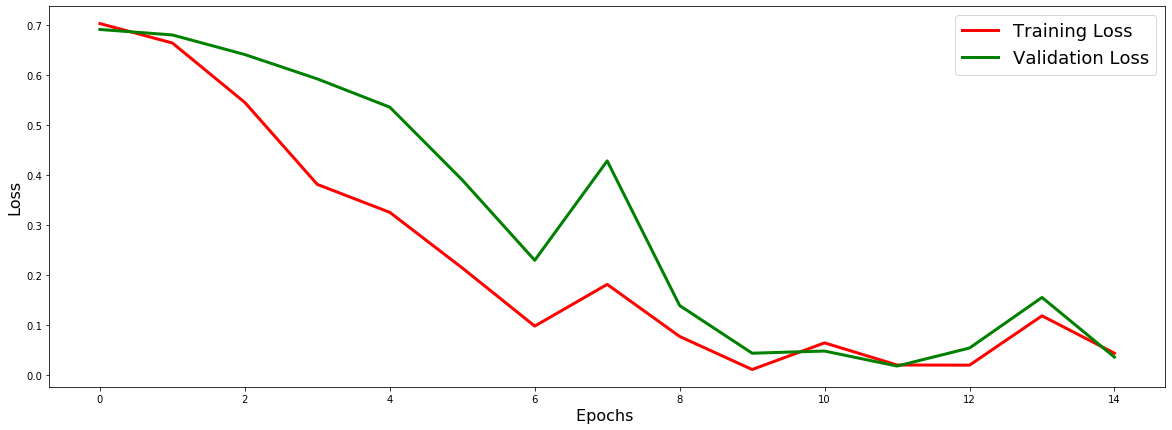

In [209]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

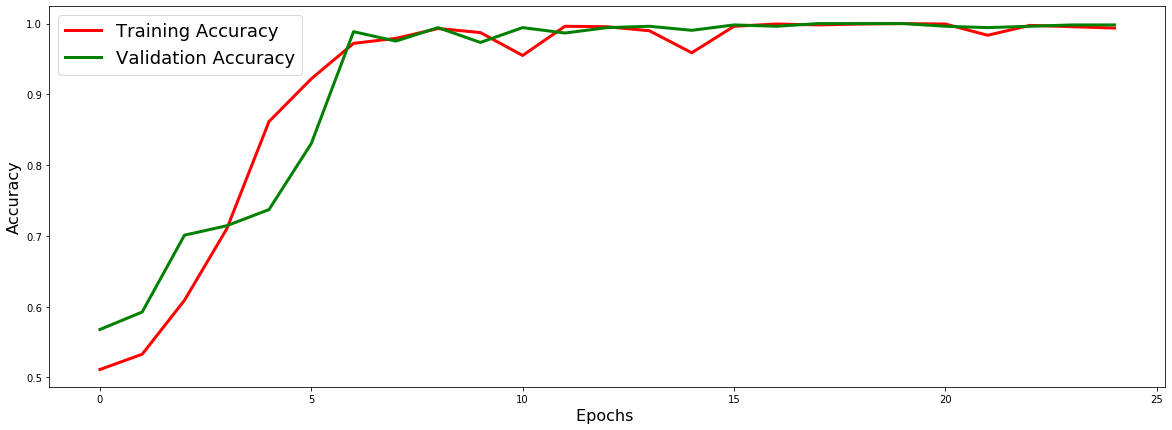

In [204]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

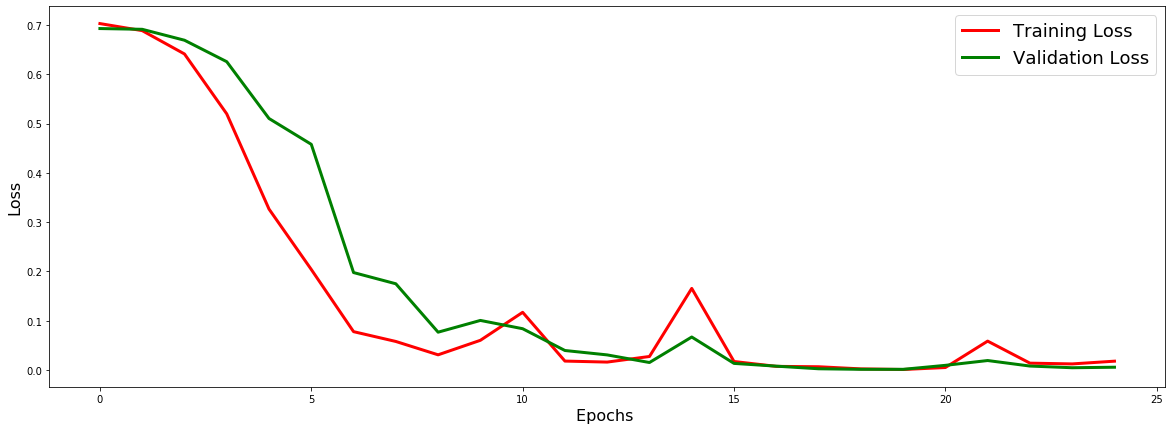

In [205]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

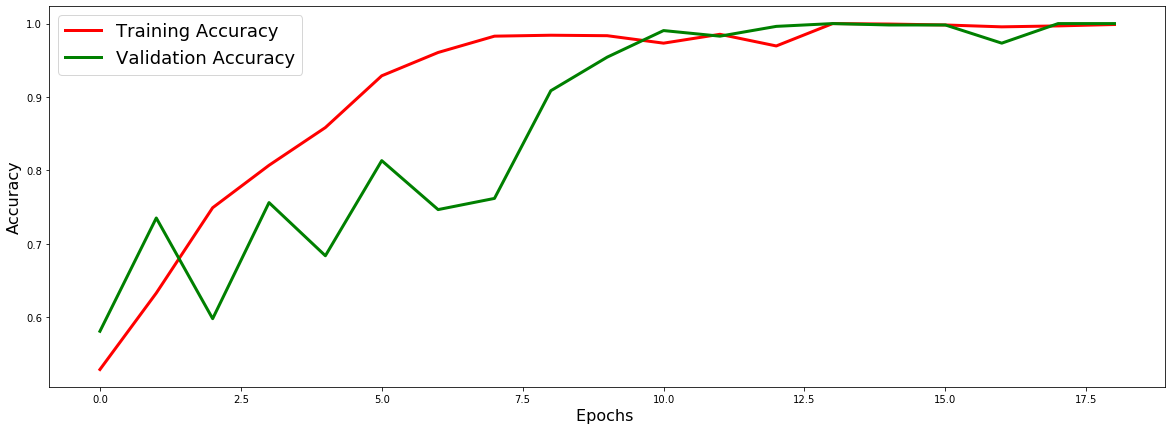

In [169]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

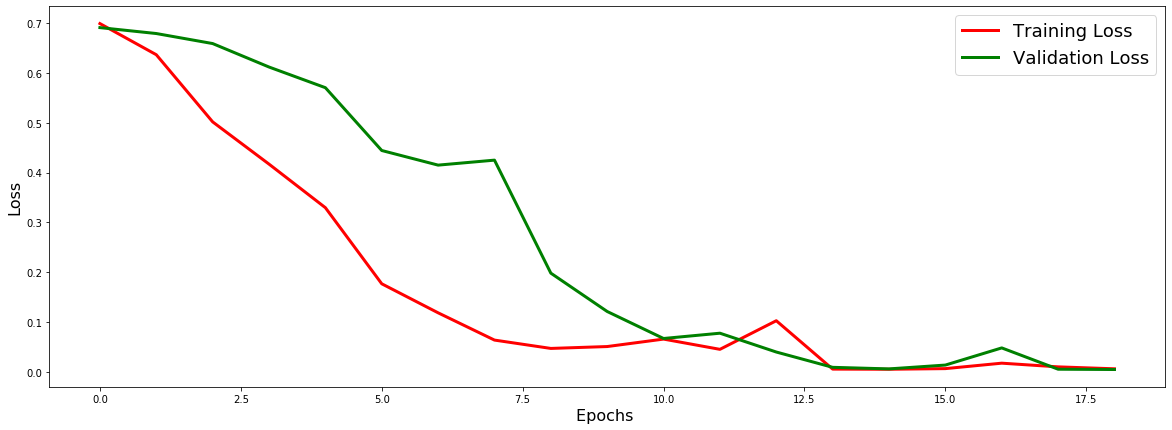

In [170]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

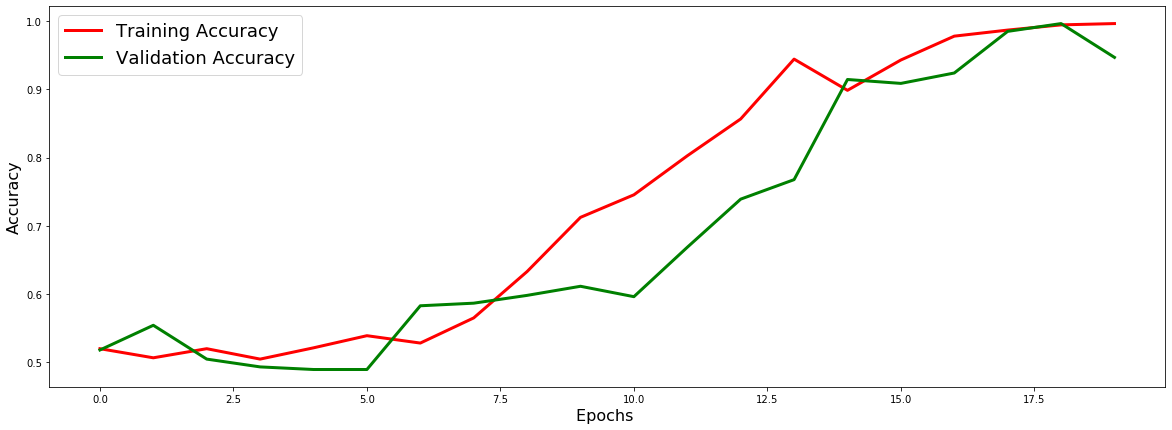

In [211]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

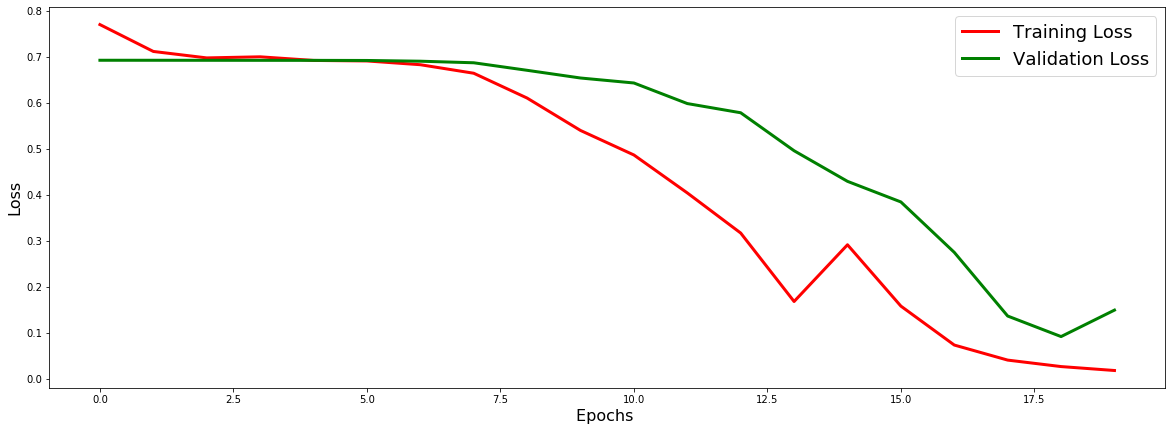

In [212]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

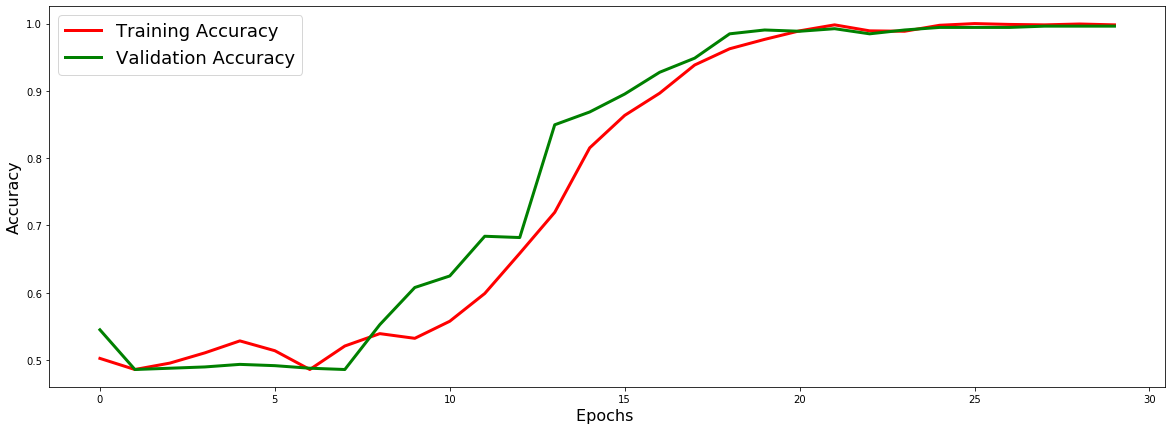

In [36]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

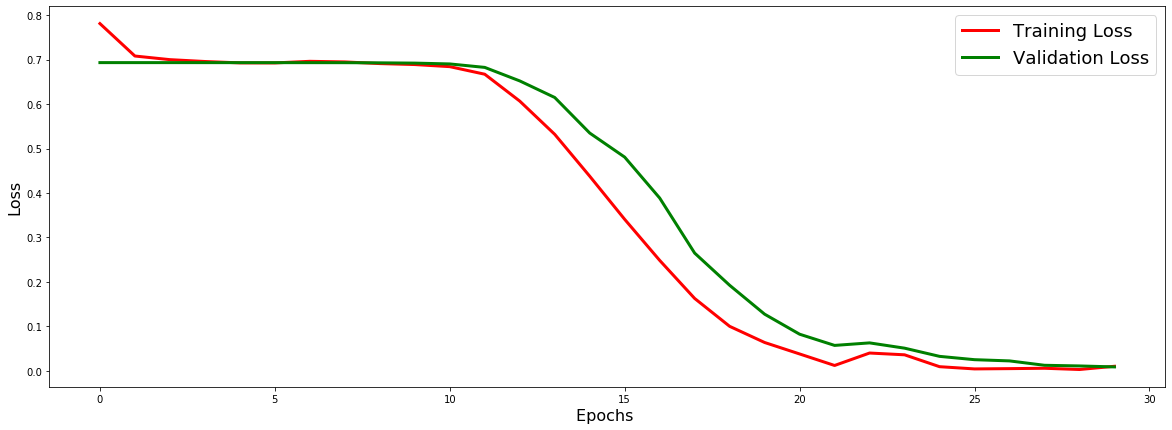

In [37]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## Evaluating using Adam at LR= 0.0001

In [210]:
y_pred = model.predict(x=X_test, batch_size=32)

In [211]:
y_pred = np.round(y_pred)

In [212]:
np.count_nonzero(y_pred == 0)

444

In [213]:
for i in range(20):
	print("Predicted=%s, Actual=%s" % (y_pred[i], y_test[i]))

Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]


In [214]:
accuracy = Accuracy()
accuracy.update_state(y_test, y_pred)
accuracy.result().numpy()

0.99222225

In [215]:
calculated_accuracy = sum(y_pred == y_test)/len(y_pred)
print(calculated_accuracy)

[0.99222222]


In [216]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

Confusion matrix, without normalization
[[444   7]
 [  0 449]]


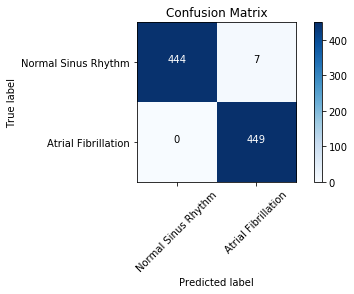

In [217]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [218]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       451
           1       0.98      1.00      0.99       449

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



In [121]:
model_path = os.path.join('models', 'CNN1')
model.save(model_path)
print('Saved trained model at %s ' % model_path)

INFO:tensorflow:Assets written to: models\CNN1\assets
Saved trained model at models\CNN1 


## Extra Trees Classifier (Randomised Decision Trees) - using 5 minute ECG segments

In [47]:
# Load normalised/filtered ECG training data - Use 5 min segments for Decision Trees
X_train, y_train = load_label_segment(train_folder, '5 min', True) 
print(X_train.shape, y_train.shape)

(600, 38400, 2) (600, 1)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=30)

In [49]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(480, 38400, 2) (480, 1)
(120, 38400, 2) (120, 1)


In [50]:
n_samples_train, n_x_train, n_y_train = X_train.shape

In [51]:
X_train_2D = X_train.reshape((n_samples_train,n_x_train*n_y_train))
print(X_train_2D.shape)

(480, 76800)


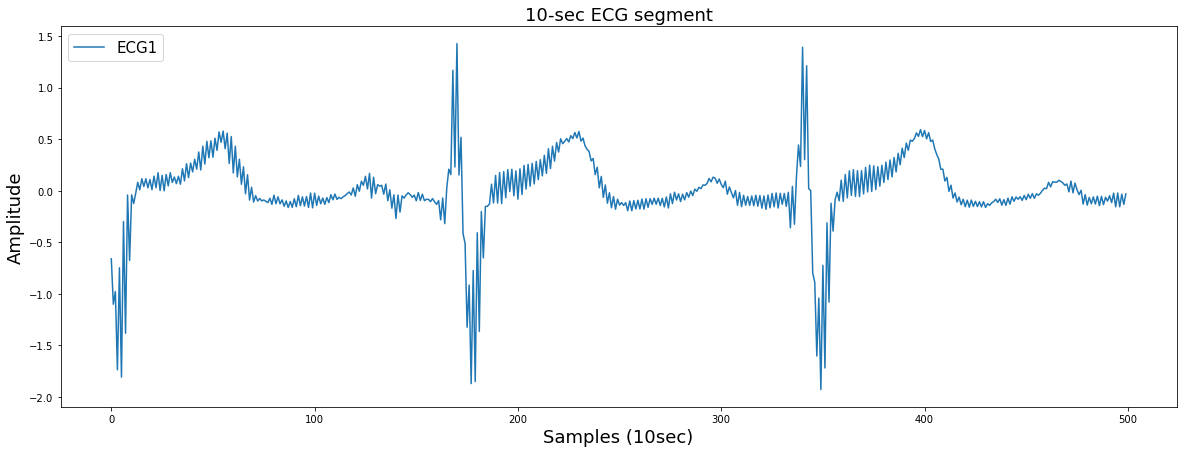

In [52]:
plt.figure(figsize=(20, 7))
plt.plot(X_train_2D[1][1000:1500]) # 
plt.xlabel('Samples (10sec)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper left", prop={'size': 15})
#fig.savefig('30-Min Normal ECG.jpg')
plt.show()

In [53]:
extratree = ExtraTreesClassifier(n_estimators=100, criterion='gini', random_state=30)

In [54]:
extratree.fit(X_train_2D, y_train)

ExtraTreesClassifier(random_state=30)

In [55]:
n_samples_test, n_x_test, n_y_test = X_test.shape

In [56]:
X_test_2D = X_test.reshape(( n_samples_test, n_x_test*n_y_test ))

In [57]:
print(X_test_2D.shape)

(120, 76800)


In [58]:
y_test[3]

array([1])

In [59]:
y_pred_extra_tree = extratree.predict(X_test_2D)

In [60]:
acc_extra_tree = extratree.score(X_test_2D, y_test)
print(acc_extra_tree)

0.7333333333333333


In [61]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_extra_tree)

Confusion matrix, without normalization
[[46 15]
 [17 42]]


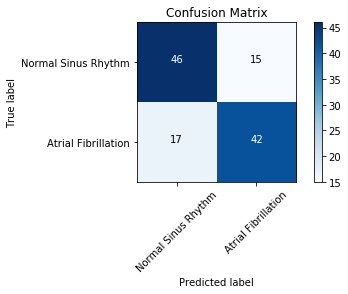

In [62]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [64]:
print(classification_report(y_true=y_test, y_pred=y_pred_extra_tree))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        61
           1       0.74      0.71      0.72        59

    accuracy                           0.73       120
   macro avg       0.73      0.73      0.73       120
weighted avg       0.73      0.73      0.73       120

